In [1]:
import pandas as pd
from code.data_module import PlainCrowdTangleDataModule, GroupId2Name, inverse_transform
from code.model import BaseModel, BiLSTMModel
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from glob import glob
import ipywidgets as widgets
from tqdm.notebook import tqdm
import pandas as pd
import torch
import seaborn as sb
import re
%load_ext tensorboard

In [2]:
# Start tensorboard
! pkill tensorboard
! rm -r /tmp/.tensorboard-info
%tensorboard --logdir lightning_logs --bind_all

Select a model to load:

In [3]:
w = widgets.Dropdown(
    options=glob('lightning_logs/*/checkpoints/*.ckpt'),
    description='Select a checkpoint:'
)
w

Dropdown(description='Select a checkpoint:', options=('lightning_logs/version_0/checkpoints/epoch=14-step=9464…

In [4]:
model_version = re.findall("version_[0-9]+", w.value)[0]
#model = BaseModel.load_from_checkpoint(w.value)
model = BiLSTMModel.load_from_checkpoint(w.value)

torch.no_grad()
model.eval()
data_module = PlainCrowdTangleDataModule(config=model.config)
data_module.setup('')
model.config, model_version

({'column_goldlabel': 'score',
  'dataset_path': '../data/crowdtanglev2_filtered.csv',
  'category_group_id': True,
  'category_type': True,
  'category_tld': True,
  'batch_size': 32,
  'category_encoded_length': 902,
  'category_encoder_out': 902,
  'learning_rate': 0.01,
  'vocab_min_freq': 10,
  'bilstm_hidden_dim': 150,
  'embedding_dim': 100,
  'vocab_size': 10663},
 'version_2')

## Validation Set Results

This shows the predictions for all rows of the validation set:

In [ ]:
df_dicts = []
val_loader = data_module.val_dataloader()
#groupid2name = GroupId2Name(model.config)
for y_lst, encoded_texts_lst, category_vectors_lst in tqdm(iter(val_loader),total=len(val_loader)):
    result = model(encoded_texts_lst, category_vectors_lst)
    for y_hat, y, encoded_text, category_vector in zip(result, y_lst, encoded_texts_lst['input_ids'], category_vectors_lst):
        decoded_categories = inverse_transform(category_vector.reshape(1, -1), model.config, data_module.class_encoder)

        df_dicts.append({**{
            'prediction': float(y_hat),
            'gold label': float(y),
            'text': data_module.tokenizer.decode(encoded_text).replace(' [PAD]','')
        },**decoded_categories})
#encoded_texts
#data_module.tokenizer.decode(encoded_texts["input_ids"][0]).replace(' [PAD]','')
pd.DataFrame.from_dict(df_dicts)

In [ ]:
df = pd.DataFrame.from_dict(df_dicts)
sb.histplot(data=df['prediction']).set_title(model_version)

## Manual Test

In [ ]:
df = pd.read_csv(dataset_path)
w_post_type = widgets.Dropdown(
    options=df['Type'].unique().tolist(),
    description='Post Type:'
)
w_group_id = widgets.Dropdown(
    options=list(df.drop_duplicates(subset=['Group Name', 'Facebook Id'])[['Group Name', 'Facebook Id']].itertuples(index=False, name=None)),
    description='Group:'
)
w_text = widgets.Textarea(
    value='',
    placeholder='post text'
)
display(w_post_type, w_group_id, w_text)

In [ ]:
class_encoding = torch.FloatTensor(data_module.class_encoder.transform([(w_group_id.value, w_post_type.value)]))
text_encoding = data_module.tokenizer([w_text.value], padding=True, truncation=True, return_tensors="pt")
result = model(text_encoding, class_encoding)
float(result)

## MSE per group

In [ ]:
# initialize MSE for each facebook group
groupid2name = GroupId2Name(model.config)
df_dicts = []
groups_mse = {}
totalmse = pl.metrics.MeanSquaredError()
for group_id, _ in groupid2name.group_id2name.items():
    groups_mse[group_id] = pl.metrics.MeanSquaredError()
    
for y_lst, encoded_texts_lst, category_vectors_lst, _ in tqdm(iter(data_module.test_dataloader()), total=len(data_module.test_dataloader())):
    y_hat_lst = model(encoded_texts_lst, category_vectors_lst)
    totalmse(y_hat_lst.squeeze(), y_lst)
    
    for y_hat, y, encoded_text, category_vector in zip(y_hat_lst, y_lst, encoded_texts_lst, category_vectors_lst):
        decoded_categories = inverse_transform(category_vector.reshape(1, -1), model.config, data_module.class_encoder)
        group_id = decoded_categories['group_id']
        
        groups_mse[group_id](y_hat.squeeze(), y)
    
        df_dicts.append({**{
            'prediction': float(y_hat),
            'gold label': float(y),
            'text': ' '.join([data_module.vocab.itos[int(t)] for t in encoded_text])
        },**decoded_categories})
for group_id, _ in groups_mse.items():
    print(groupid2name(group_id) + ':', float(groups_mse[group_id].compute()))


In [ ]:
totalmse.compute()

In [ ]:
pd.DataFrame.from_dict(df_dicts)

## MSE Without Groups (e.g. for Rtnews)

In [5]:
df_dicts = []
mse = pl.metrics.MeanSquaredError()
for y_lst, encoded_texts_lst, category_vectors_lst, _ in tqdm(iter(data_module.test_dataloader()), total=len(data_module.test_dataloader())):
    y_hat_lst = model(encoded_texts_lst, category_vectors_lst)
    mse(y_hat_lst.squeeze(), y_lst)
    
    for y_hat, y, encoded_text, category_vector in zip(y_hat_lst, y_lst, encoded_texts_lst, category_vectors_lst):
        decoded_categories = inverse_transform(category_vector.reshape(1, -1), model.config, data_module.class_encoder)
           
        df_dicts.append({**{
            'prediction': float(y_hat),
            'gold label': float(y),
            'text': ' '.join([data_module.vocab.itos[int(t)] for t in encoded_text])
        },**decoded_categories})


  0%|          | 0/211 [00:00<?, ?it/s]

In [6]:
mse.compute()

tensor(6.9297)

In [7]:
from pathlib import Path
dataset_path = Path(model.config['dataset_path'])
dataset_name = dataset_path.stem
figure_path = Path('./figures/' + dataset_name + '/')
figure_path.mkdir(parents=True, exist_ok=True)

In [8]:
df = pd.DataFrame.from_dict(df_dicts)
df

,prediction,gold label,text,group_id,post_type,domain
0,2.945557,1.811011,spot on . <pad> <pad> <pad> <pad> <pad> <pad> ...,1859718597614634,Photo,facebook
1,2.436858,0.377212,https //youtu . <unk> magical blm protests pre...,291686185301,Video,youtu
2,1.370781,0.000000,us defense spending is more than the next 10 c...,229114357132790,Photo,facebook
3,0.920641,3.622021,a shaman was asked what is poison ? <unk> beyo...,1859718597614634,Photo,facebook
4,1.473941,0.000000,the global depopulation agenda maintain humani...,291686185301,Photo,facebook
...,...,...,...,...,...,...
6723,2.656764,0.806925,<unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad...,215950779333752,Photo,facebook
6724,0.611009,0.000000,sound medicine ! ✨🙏✨ become a certified sound ...,229114357132790,Photo,facebook
6725,0.411495,0.226327,<unk> here folks . . . see what is behind the ...,291686185301,Photo,facebook
6726,0.590041,0.044287,if i kill the part of me that ' s an <unk> wil...,805671206178851,Status,


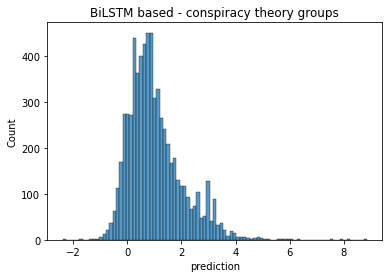

In [9]:
plt = sb.histplot(data=df['prediction'])
plt.set_title('BiLSTM based - conspiracy theory groups')
plt.figure.savefig(f'{figure_path}/bilstm_dist.pdf')